# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [ ]:
import numpy as np
import tensorflow as tf
import sscs
import matplotlib.pyplot as plt

## 2 - Download and extract dataset SSCS

In [2]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [ ]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

In [13]:
ckpt_dir = './Checkpoints/mask_voas_treino1.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino2_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino3_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino4_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino5_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino6_tracked.keras'
mask_voas_cnn = sscs.mask_voas_cnn_model(l_rate = 2e-3)

#print(mask_voas_cnn.summary())

sscs.load_weights(mask_voas_cnn, ckpt_dir=ckpt_dir)
#sscs.train(mask_voas_cnn, ds_train, ds_val, epochs=50, save_model=True, ckpt_dir=ckpt_dir)  

In [5]:
ckpt_dir = './Checkpoints/downsample_voas_cnn.keras'
downsample_voas_cnn = sscs.downsample_voas_cnn_model()

#print(mask_voas_cnn.summary())

#sscs.load_weights(downsample_voas_cnn)
#sscs.train(downsample_voas_cnn, ds_train, ds_val, epochs=30, save_model=False, ckpt_dir=ckpt_dir)  

## 4 - Evaluation with F-Score

In [6]:
songs = sscs.pick_songlist(amount=300, split='test')

def multivoice_f_score(song):
    mix, s, a, t, b = sscs.read_all_voice_splits(song)
    s_pred, a_pred, t_pred, b_pred = mask_voas_cnn.predict(mix)

    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

    s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
    a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
    t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
    b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
    mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
    mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

    s_fscore = sscs.f_score(s, s_pred_postproc)
    a_fscore = sscs.f_score(a, a_pred_postproc)
    t_fscore = sscs.f_score(t, t_pred_postproc)
    b_fscore = sscs.f_score(b, b_pred_postproc)

    return [s_fscore, a_fscore, t_fscore, b_fscore]

#f_scores = np.array(list(map(multivoice_f_score, songs)))
#f_scores = f_scores.T
#np.save('./Evaluation_Data/f-scores_treino6_tracked.npy', f_scores)

In [7]:
f_scr1 = np.load("./Evaluation_Data/f-scores_treino1.npy")
f_scr2 = np.load("./Evaluation_Data/f-scores_treino2_tracked.npy")
f_scr3 = np.load("./Evaluation_Data/f-scores_treino3_tracked.npy")
f_scr4 = np.load("./Evaluation_Data/f-scores_treino4_tracked.npy")
f_scr5 = np.load("./Evaluation_Data/f-scores_treino5_tracked.npy")
f_scr6 = np.load("./Evaluation_Data/f-scores_treino5_tracked.npy")

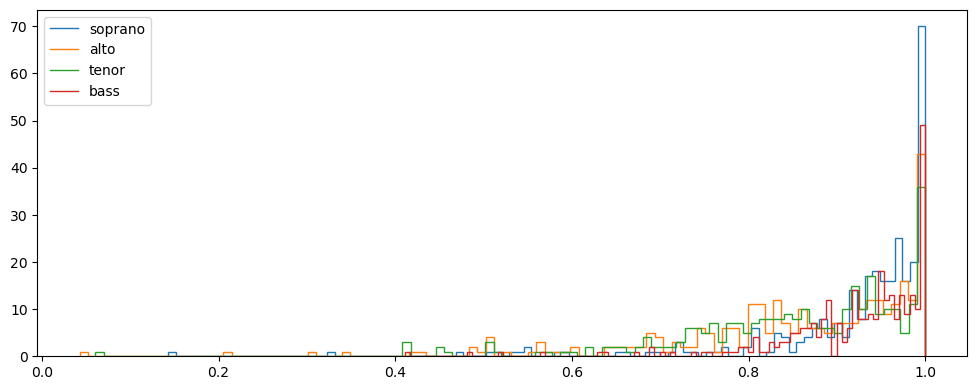

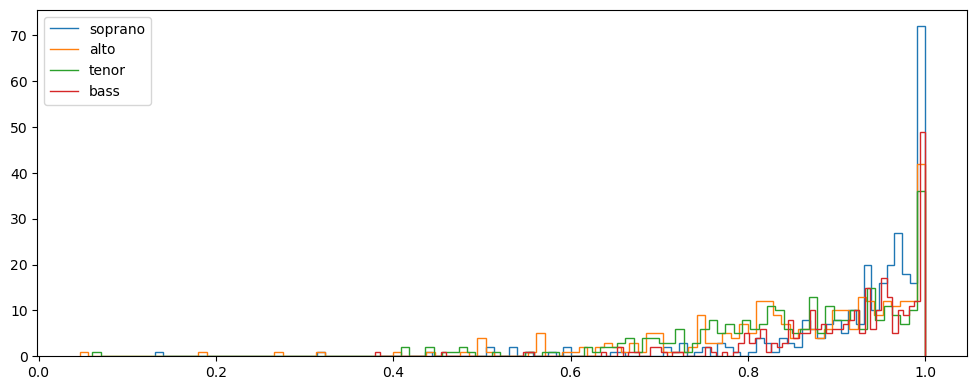

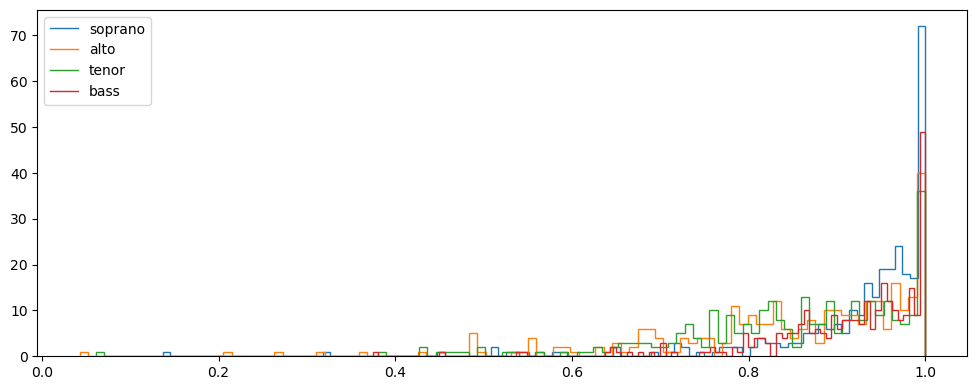

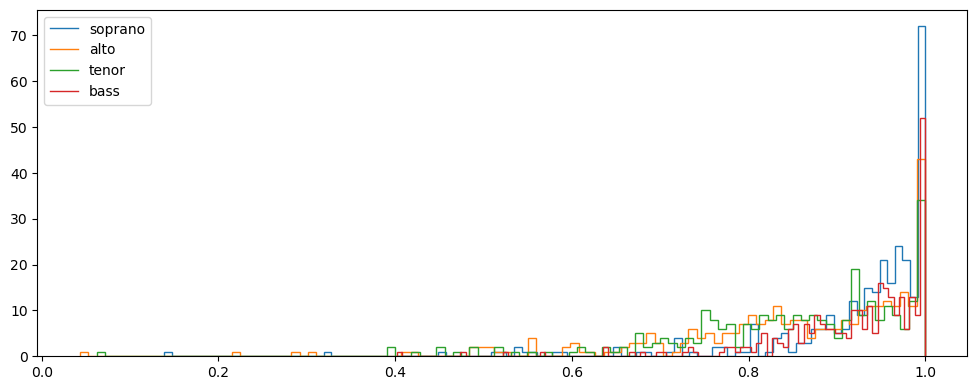

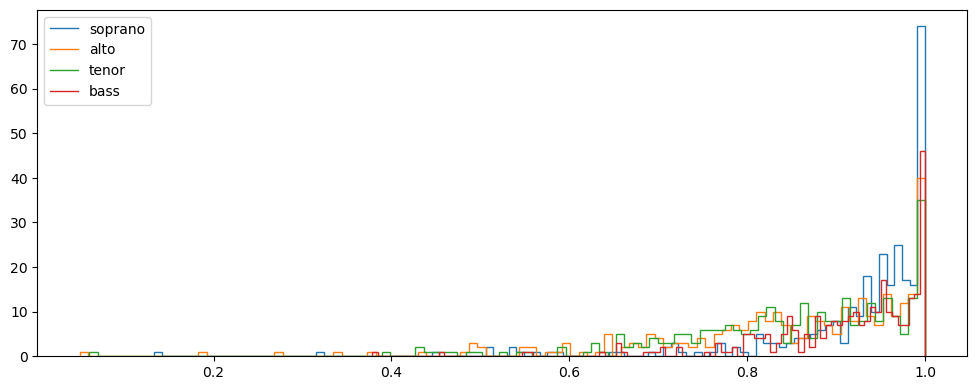

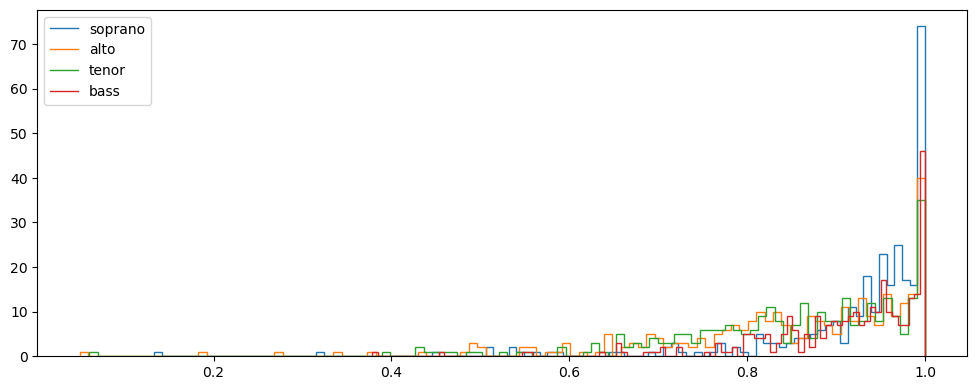

In [8]:
sscs.joint_f_histograms(f_scr1)
sscs.joint_f_histograms(f_scr2)
sscs.joint_f_histograms(f_scr3)
sscs.joint_f_histograms(f_scr4)
sscs.joint_f_histograms(f_scr5)
sscs.joint_f_histograms(f_scr6)

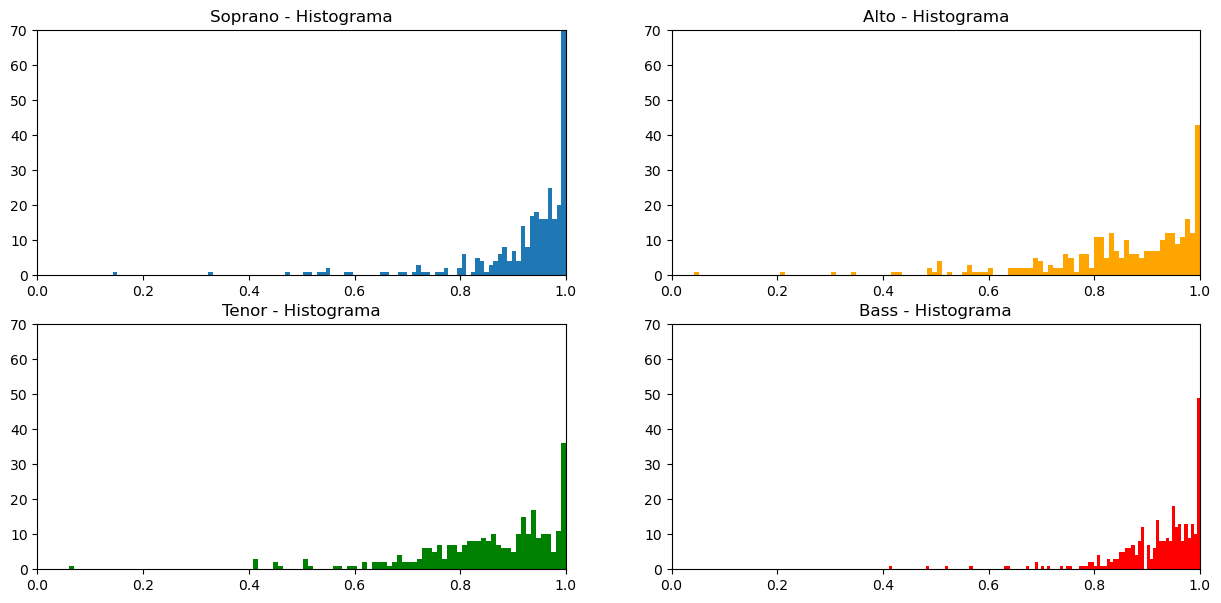

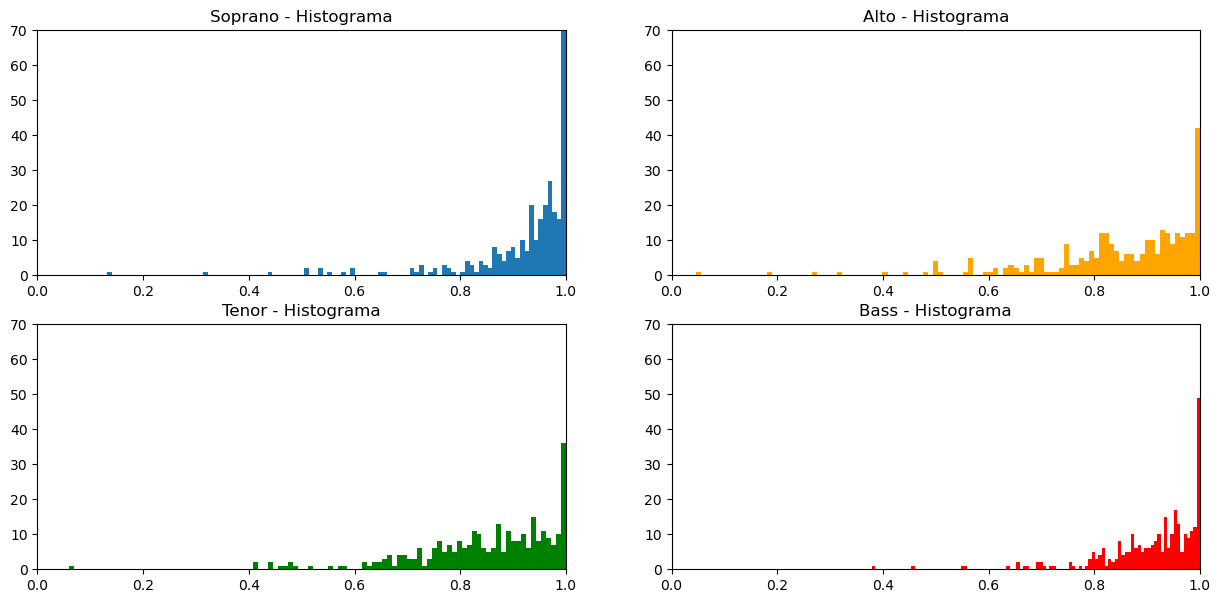

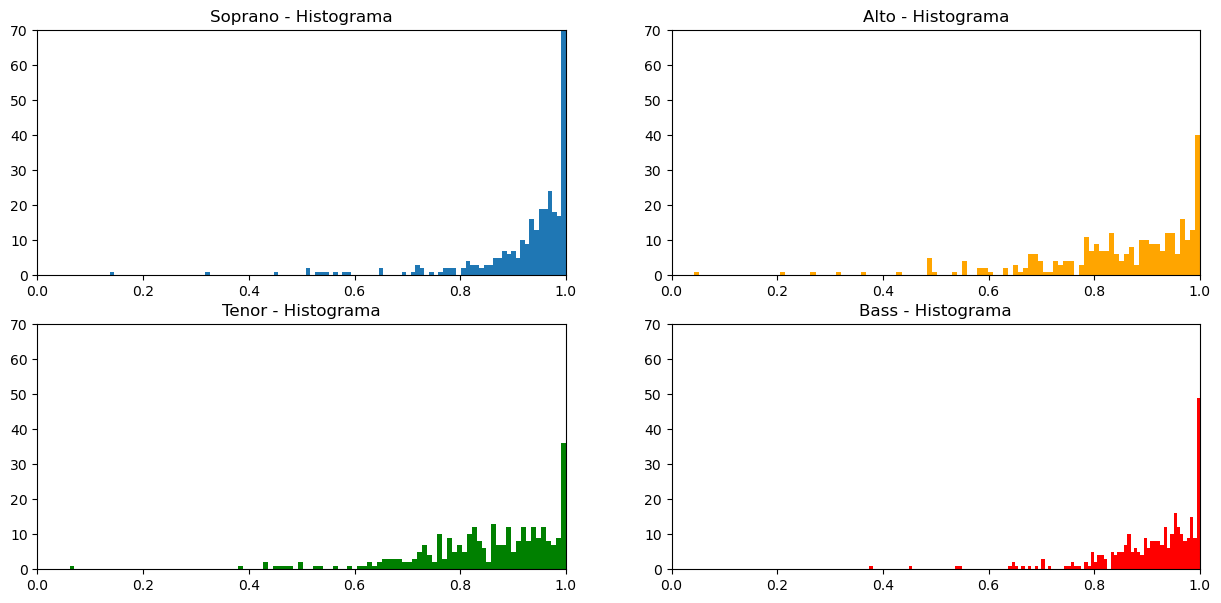

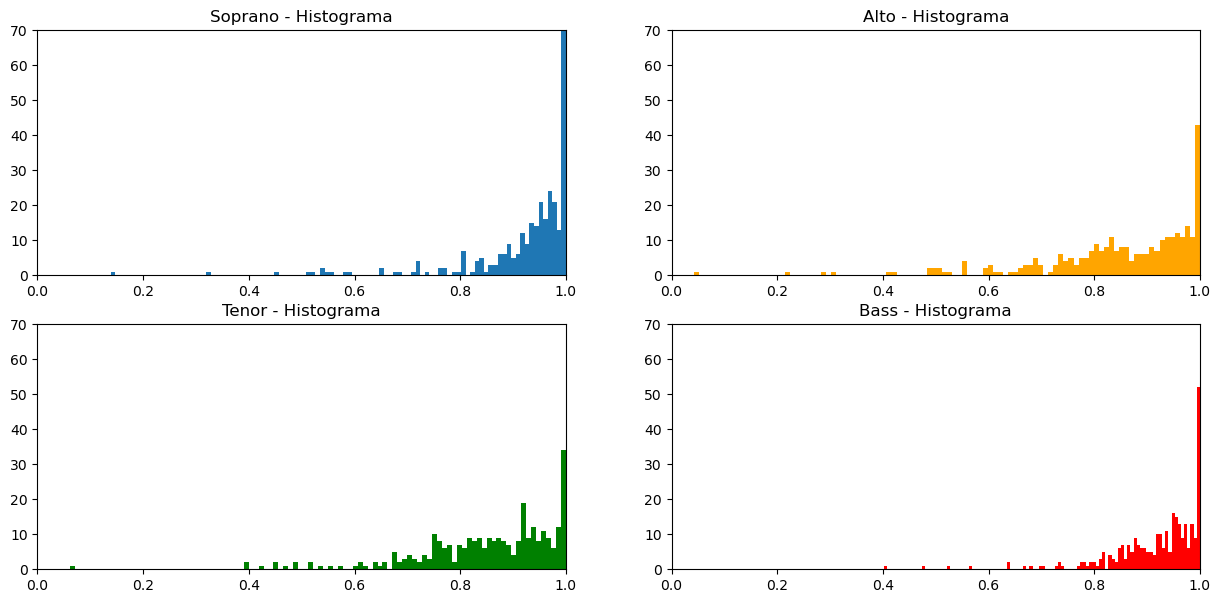

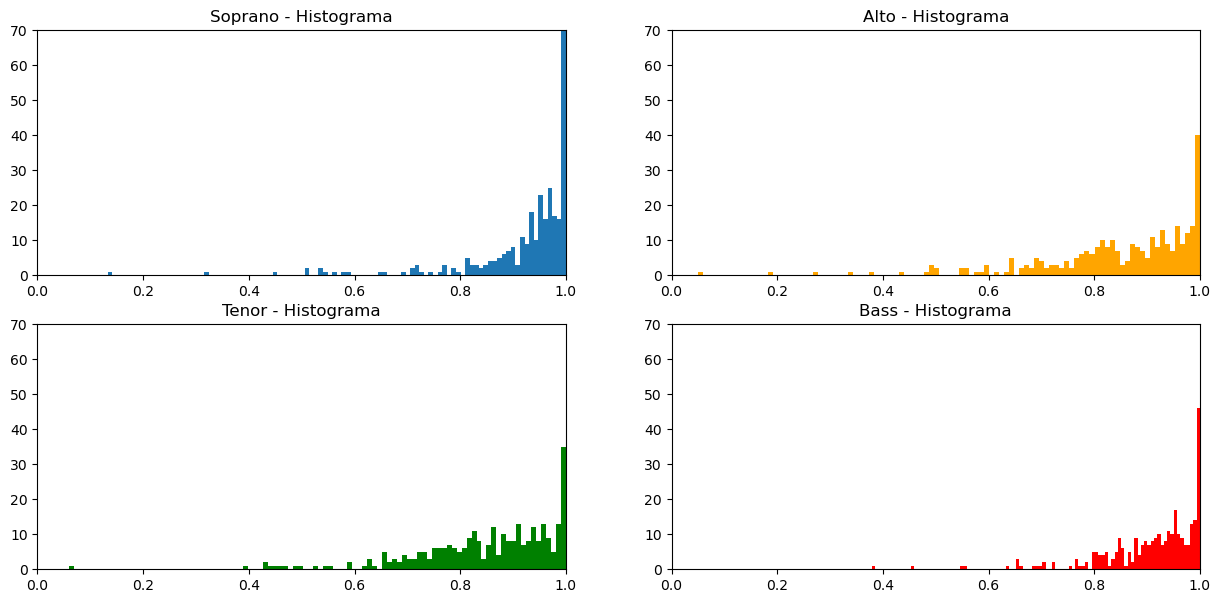

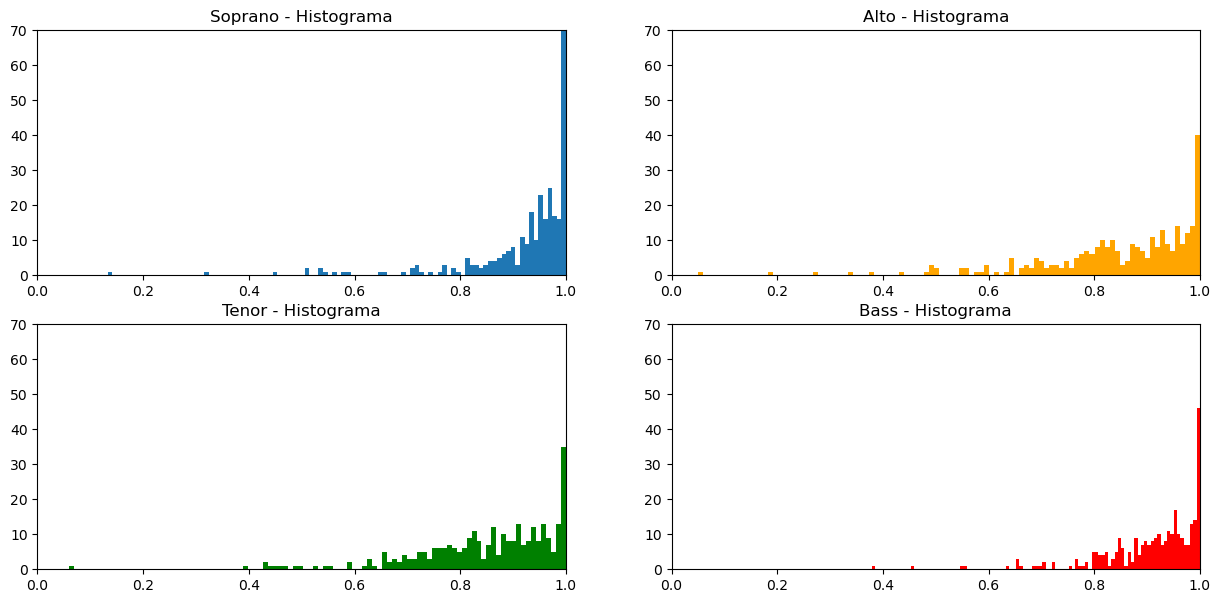

In [9]:
sscs.voice_f_histograms(f_scr1)
sscs.voice_f_histograms(f_scr2)
sscs.voice_f_histograms(f_scr3)
sscs.voice_f_histograms(f_scr4)
sscs.voice_f_histograms(f_scr5)
sscs.voice_f_histograms(f_scr6)

0.9557955200295666 0.8877555095408922 0.8796407407425293 0.941631396379784


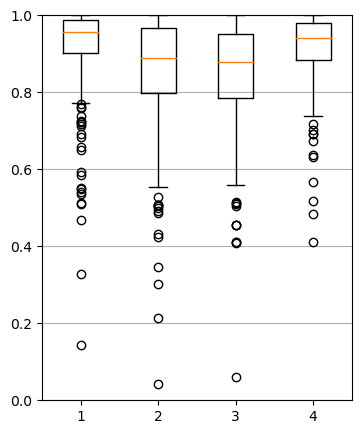

0.957410596232581 0.8927647707720616 0.8726177014909005 0.9331590105945149


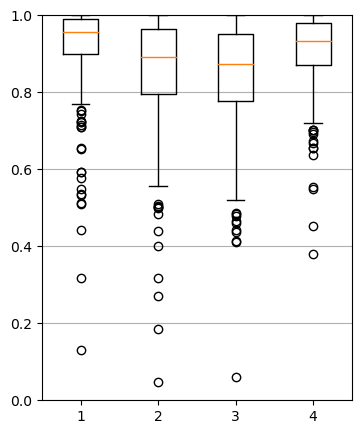

0.9568291525862096 0.8871839491155689 0.8696288562500029 0.934310202302143


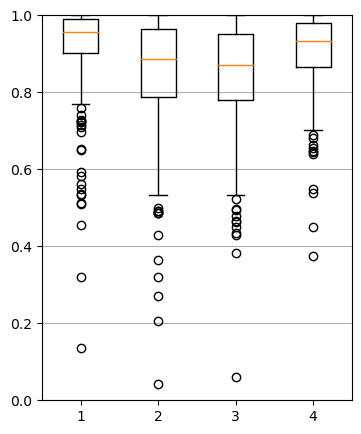

0.9549946081196607 0.8847639870934988 0.8751952625000028 0.9411902525184301


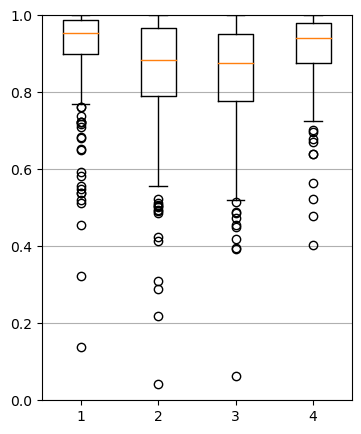

0.9557942208333359 0.8840575671875028 0.874283013427803 0.9327147937500027


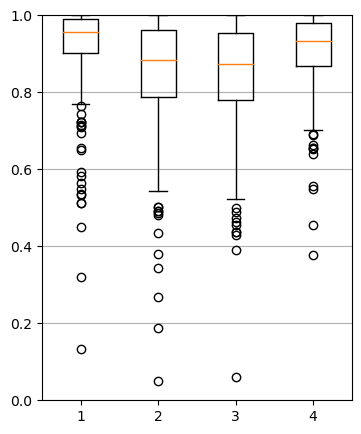

0.9557942208333359 0.8840575671875028 0.874283013427803 0.9327147937500027


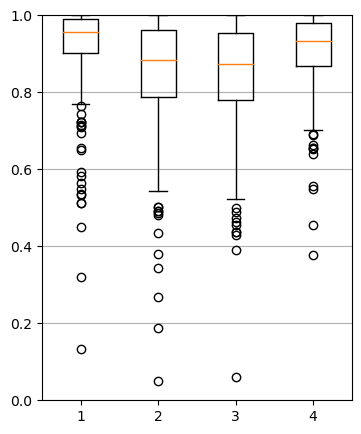

In [10]:
sscs.boxplot(f_scr1)
sscs.boxplot(f_scr2)
sscs.boxplot(f_scr3)
sscs.boxplot(f_scr4)
sscs.boxplot(f_scr5)
sscs.boxplot(f_scr6)

## 5 - Playground

3/3 [==============================] - 0s 98ms/step
F-Scores:
Soprano: 0.9700806505494531
Alto: 0.9658309939560465
Tenor: 0.9605081917582443
Bass: 0.9643715159340684



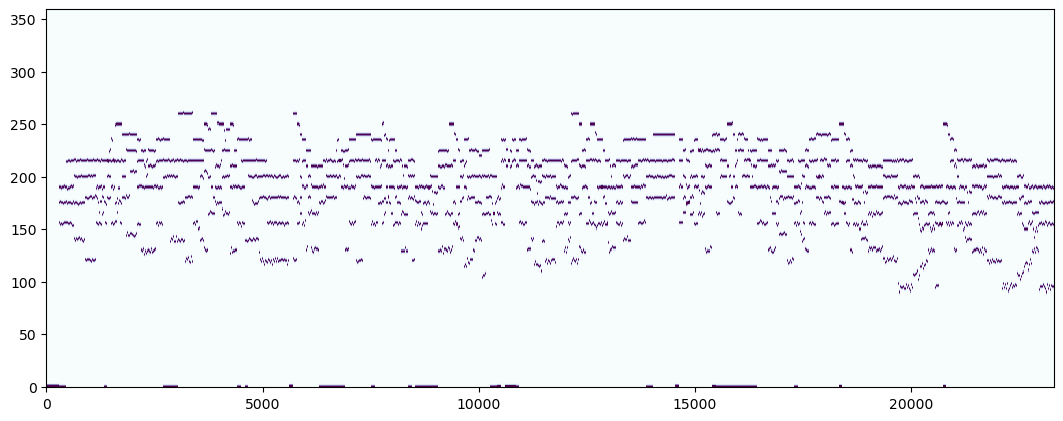

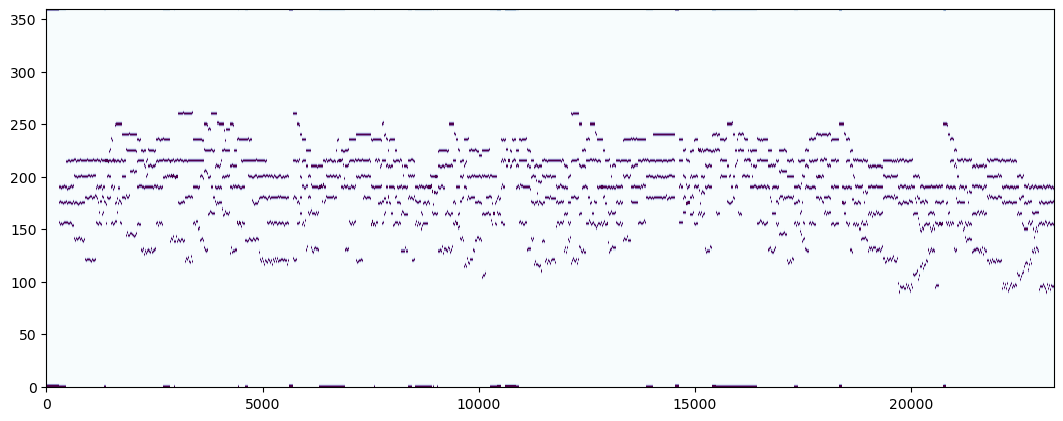

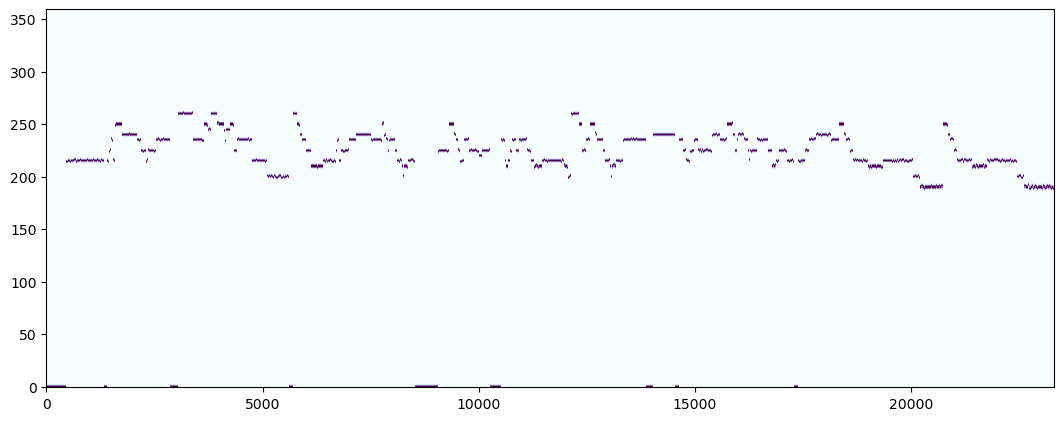

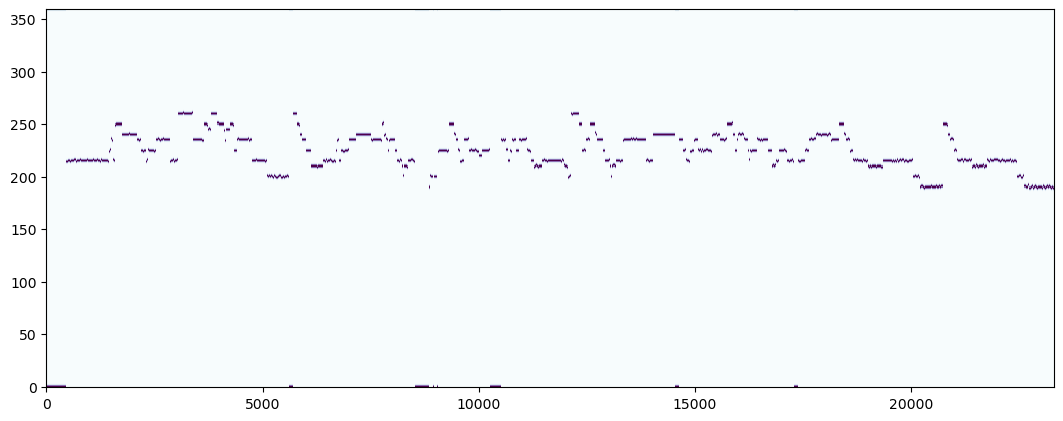

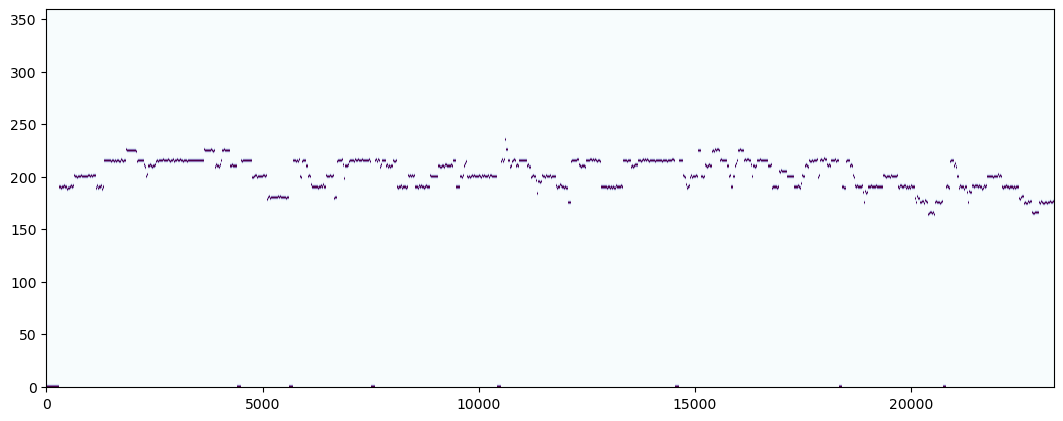

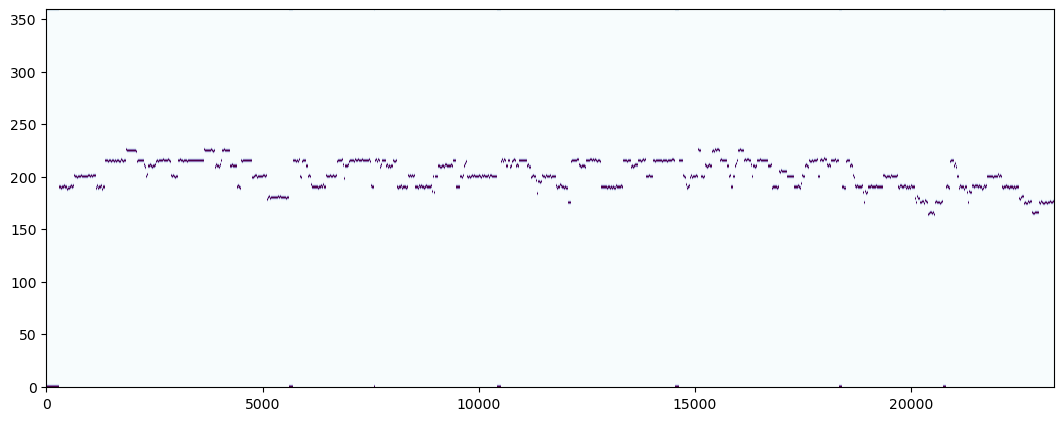

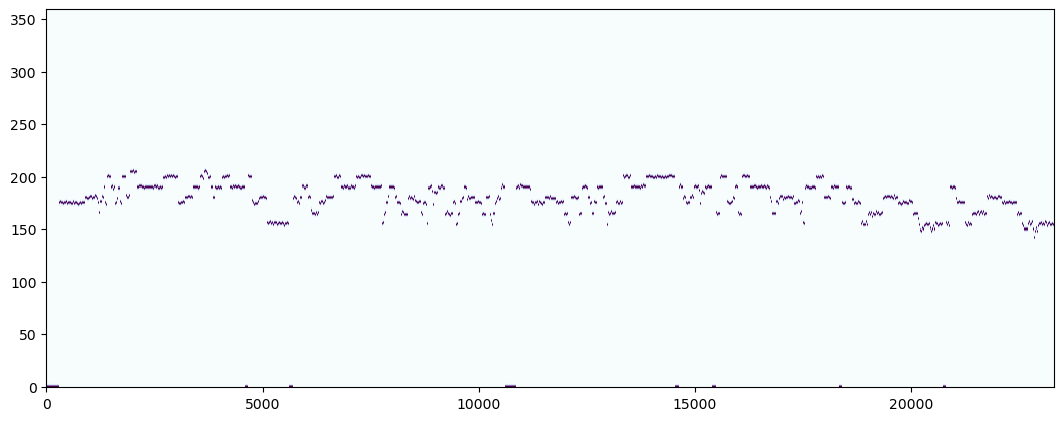

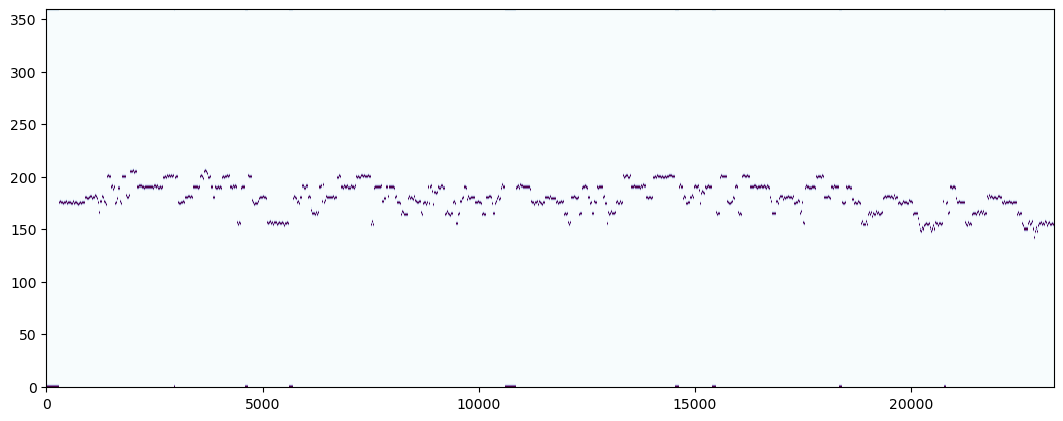

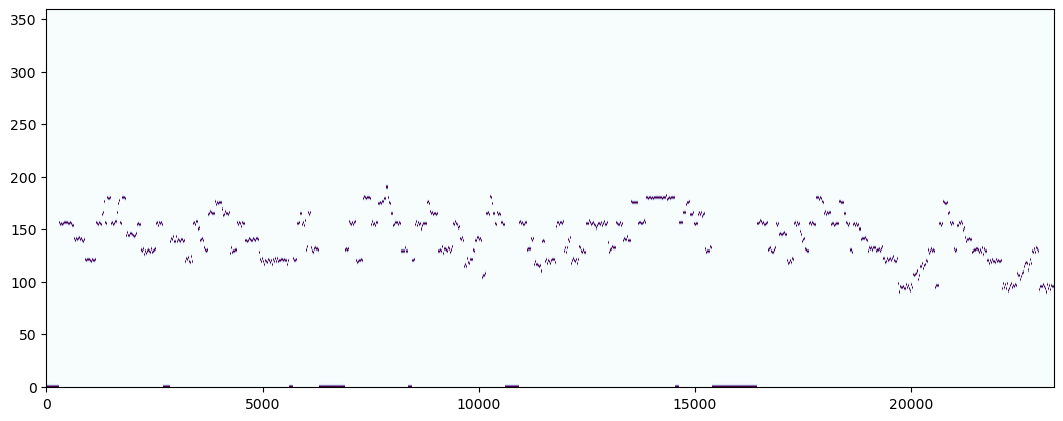

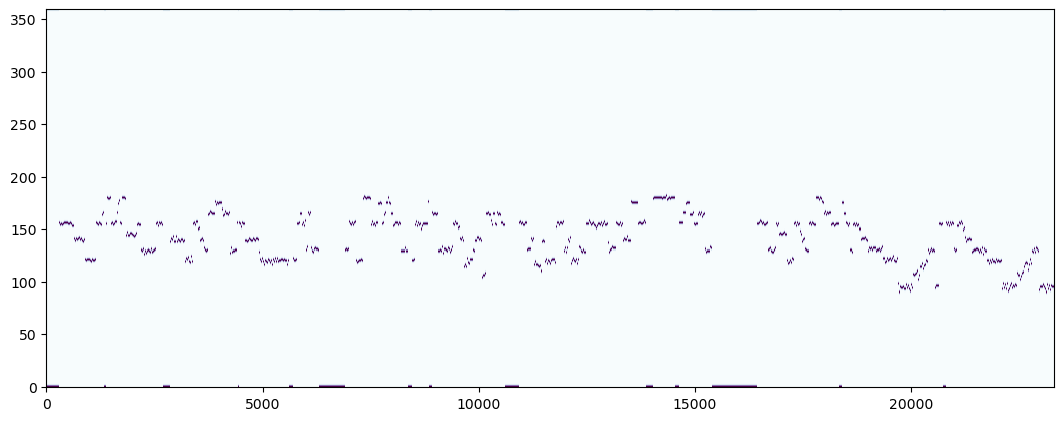

In [23]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = mask_voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

s_fscore = sscs.f_score(s, s_pred_postproc)
a_fscore = sscs.f_score(a, a_pred_postproc)
t_fscore = sscs.f_score(t, t_pred_postproc)
b_fscore = sscs.f_score(b, b_pred_postproc)

print("F-Scores:")
print(f"Soprano: {s_fscore}")
print(f"Alto: {a_fscore}")
print(f"Tenor: {t_fscore}")
print(f"Bass: {b_fscore}")
print()

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')